# 大黒海釣り施設、アジ釣果分析その１

## モジュールのインポート

In [1]:
# モジュールのインポート

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import datetime
import jpholiday
import sqlite3
import seaborn as sns

# グラフサイズ変更。既定より大きくする

plt.rcParams['figure.figsize'] = [15, 10]

# seaborn グラフにグリッド線を追加

sns.set()
sns.set_style("whitegrid", {'grid.linestyle': '--'})

## データのロードと変換

In [37]:
from piersfan.config import Config
print(Config.get_db_path())

/home/psadmin/work/blog/choka/fishing-piers-fan/data/fishing_result.sqlite3


In [23]:
# 大黒、アジに絞ってSQLite3データベースを検索

#conn = sqlite3.connect("../data/fishing_result.db")
conn = sqlite3.connect("../data/fishing_result.sqlite3")
sql = '''
select
    r.Date,
    r.Species,
    r.Count,
    r.SizeMin,
    r.SizeMax,
    c.WaterTemp,
    c.Quantity
from
    fishing_results r,
    fishing_comments c
where
    r.Date = c.Date
    and r.Point = c.Point
    and r.Species = 'アジ'
    and r.Point = 'daikoku'
    and r.Date > '2018-01-01'
'''
df=pd.read_sql_query(sql, conn)
df.head()

,Date,Species,Count,SizeMin,SizeMax,WaterTemp,Quantity
0,2018-02-18,アジ,3,22.0,23.0,10.0,119.0
1,2018-02-20,アジ,4,23.0,25.0,10.0,56.0
2,2018-02-21,アジ,2,19.0,21.0,10.3,44.0
3,2018-02-23,アジ,3,22.0,24.0,10.5,31.0
4,2018-02-26,アジ,4,22.0,23.0,10.5,36.0


In [24]:
# 土日祝日化判定列を追加

df['Date'] = pd.to_datetime(df.Date)
def isBizDay(Date):
    if Date.weekday() >= 5 or jpholiday.is_holiday(Date):
        return 'Holiday'
    else:
        return 'WeekDay'

df['BizDay'] = df.apply(lambda x: isBizDay(x.Date), axis=1)

# 日付を索引にセット

df = df.set_index('Date')
df.head()

,Species,Count,SizeMin,SizeMax,WaterTemp,Quantity,BizDay
Date,,,,,,,
2018-02-18,アジ,3,22.0,23.0,10.0,119.0,Holiday
2018-02-20,アジ,4,23.0,25.0,10.0,56.0,WeekDay
2018-02-21,アジ,2,19.0,21.0,10.3,44.0,WeekDay
2018-02-23,アジ,3,22.0,24.0,10.5,31.0,WeekDay
2018-02-26,アジ,4,22.0,23.0,10.5,36.0,WeekDay


## 平日、休日の入場者数比較

<AxesSubplot:xlabel='BizDay', ylabel='Quantity'>

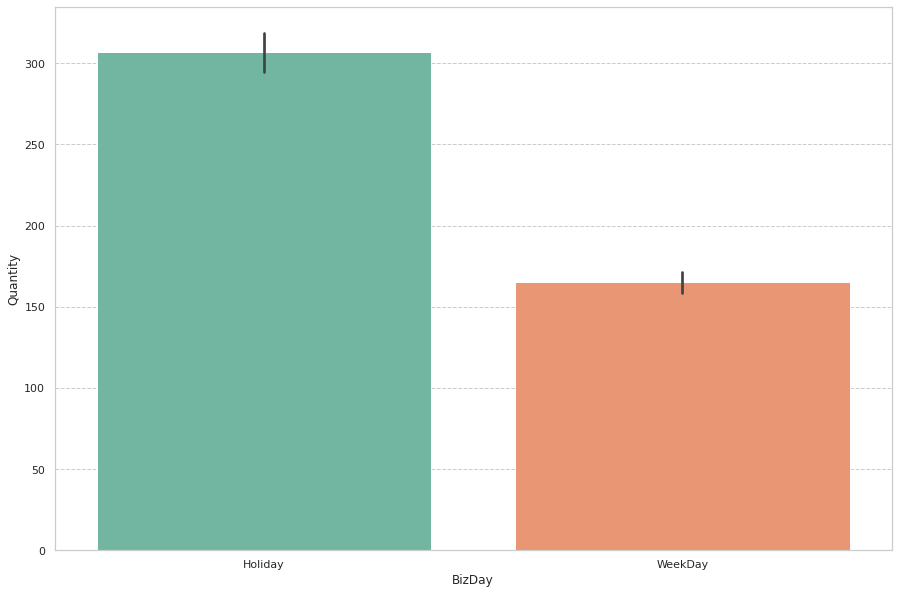

In [25]:
# 入場者数の比較

sns.barplot(x='BizDay', y='Quantity', data=df, palette='Set2')

In [26]:
# 平日と休日の比較

df.groupby('BizDay').mean()

,Count,SizeMin,SizeMax,WaterTemp,Quantity
BizDay,,,,,
Holiday,219.284375,14.340625,25.706250,18.639871,306.785489
WeekDay,221.086420,14.577160,26.787037,18.721787,165.060465


In [27]:
# seaborn でプロットしやすいようにデータフレームを横縦変換する

df2 = df[['Count', 'SizeMin', 'SizeMax','WaterTemp', 'Quantity']]
df2 = df2.stack().reset_index()
df2 = df2.rename(columns={'level_1': 'Metric', 0: 'Value'})

# 平日、休日判定列を追加

df2['BizDay'] = df2.apply(lambda x: isBizDay(x.Date), axis=1)

# 日付を索引にセットして、各年月日列を追加

df3 = df2.set_index('Date')
df3['Year'] = df3.index.year
df3['Month'] = df3.index.month
df3['DayOfYear'] = df3.index.dayofyear
df3['WeekOfYear'] = df3.index.strftime('%U').astype(int) # df3.index.week
df3.head()

,Metric,Value,BizDay,Year,Month,DayOfYear,WeekOfYear
Date,,,,,,,
2018-02-18,Count,3.0,Holiday,2018,2,49,7
2018-02-18,SizeMin,22.0,Holiday,2018,2,49,7
2018-02-18,SizeMax,23.0,Holiday,2018,2,49,7
2018-02-18,WaterTemp,10.0,Holiday,2018,2,49,7
2018-02-18,Quantity,119.0,Holiday,2018,2,49,7


<AxesSubplot:xlabel='Month', ylabel='Value'>

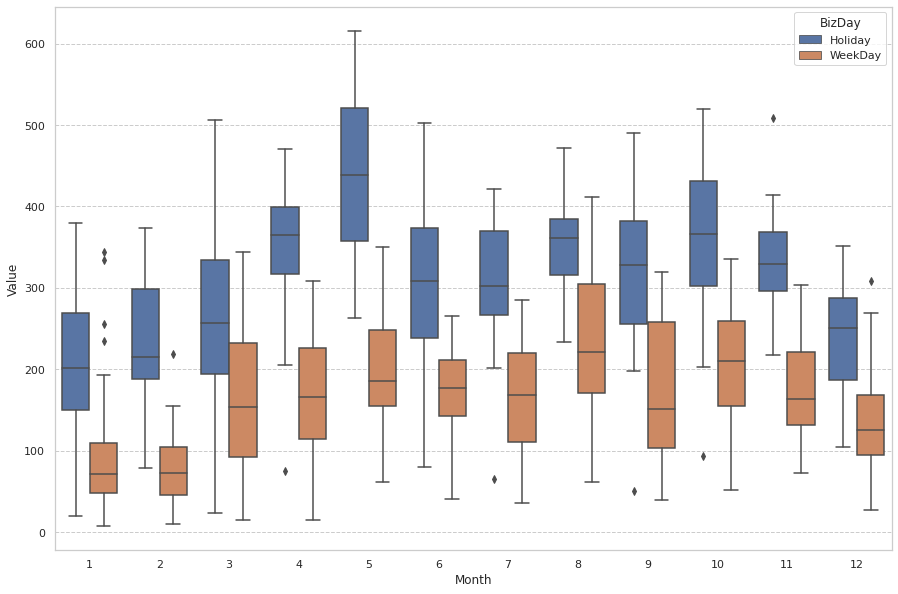

In [28]:
# 月別の入場者数の分析

df6 = df3.loc[df3['Metric'].isin(['Quantity'])]
sns.boxplot(data = df6, x="Month", y="Value", hue="BizDay")

## アジの釣果サイズの比較

<AxesSubplot:xlabel='Metric', ylabel='Value'>

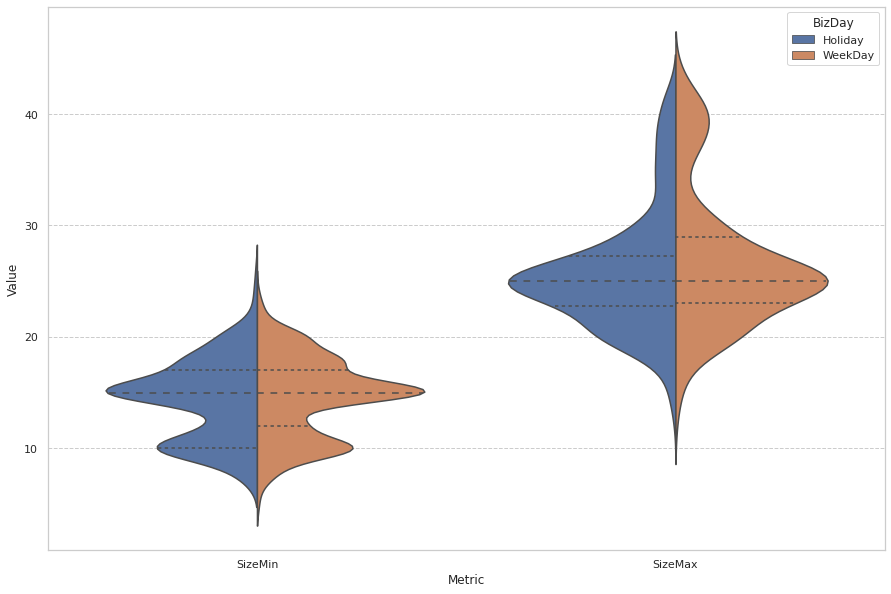

In [29]:
# アジの最小、最大サイズに絞り込んで平日、休日の分布図を比較

df5 = df3.loc[df3['Metric'].isin(['SizeMax', 'SizeMin'])]
sns.violinplot(data = df5, x="Metric", y="Value", hue="BizDay", 
               split=True, inner="quart")

<AxesSubplot:xlabel='Month', ylabel='Value'>

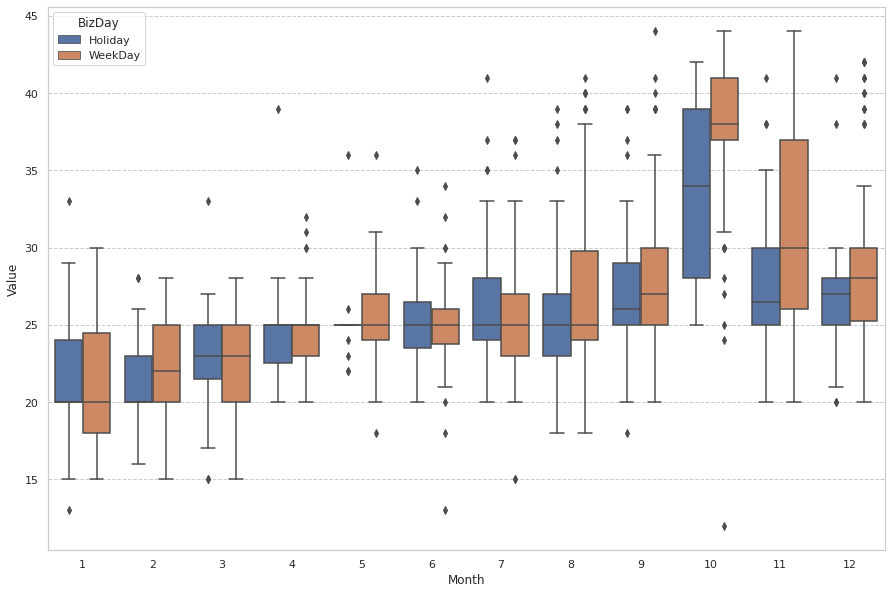

In [30]:
# 月別のアジ最大サイズの分析

df6 = df3.loc[df3['Metric'].isin(['SizeMax'])]
sns.boxplot(data = df6, x="Month", y="Value", hue="BizDay")

## 年度別のアジ釣果分析

<AxesSubplot:xlabel='Month', ylabel='Value'>

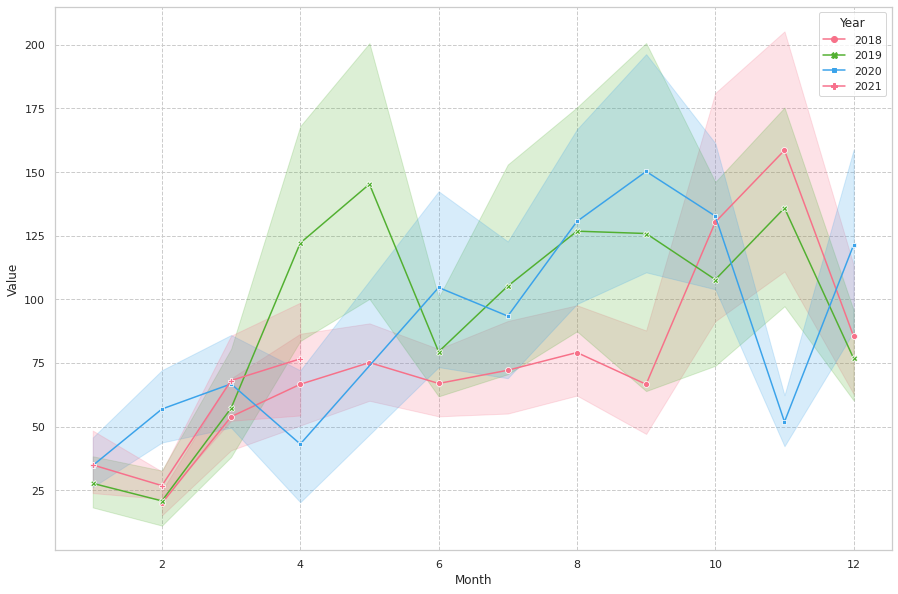

In [31]:
# 平日の釣果に絞り込む

df7 = df3.query('BizDay == "WeekDay"')

# 年度別アジ釣果数の比較

df8 = df7.loc[df7['Metric'].isin(['Count'])]
sns.lineplot(data=df7, x='Month', y='Value', hue='Year', style='Year',
            markers=True, dashes=False, palette="husl")

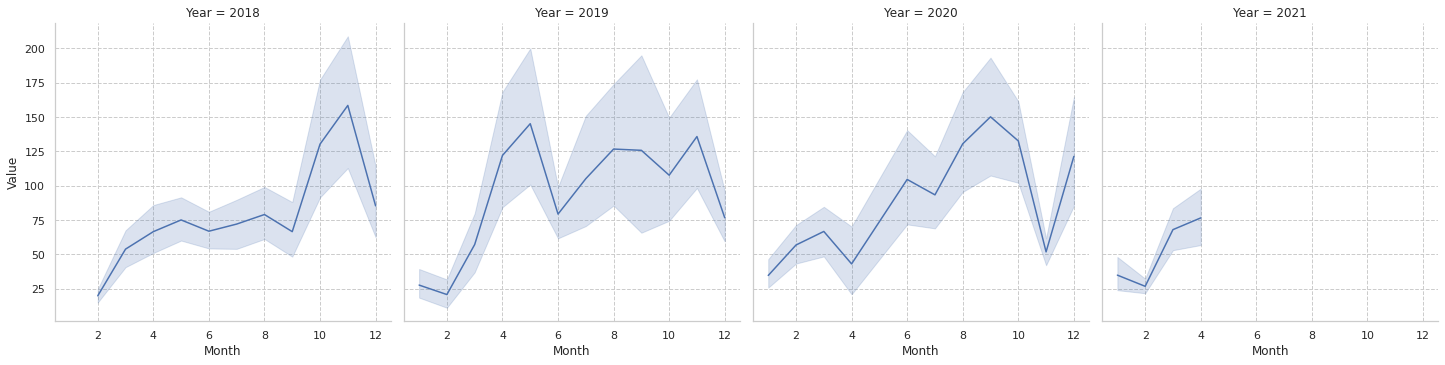

In [32]:
# 年度別アジ釣果数

sns.relplot(data=df7, x='Month', y='Value', col='Year', kind="line")

<AxesSubplot:xlabel='Month', ylabel='Value'>

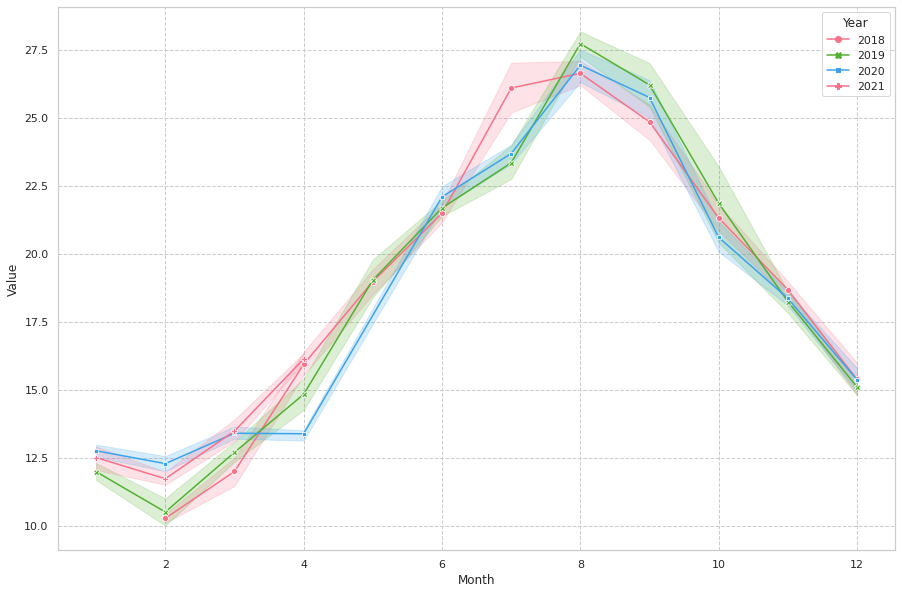

In [33]:
# 海水温の比較

df9 = df7.loc[df7['Metric'].isin(['WaterTemp'])]
sns.lineplot(data=df9, x='Month', y='Value', hue='Year', style='Year',
            markers=True, dashes=False, palette="husl")

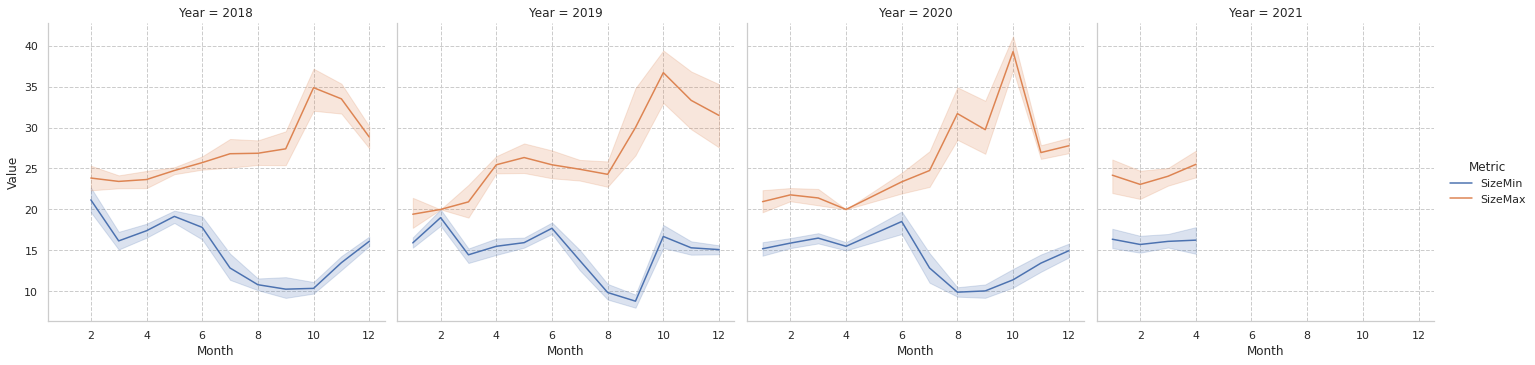

In [34]:
# アジ釣果サイズの比較

df10 = df7.loc[df7['Metric'].isin(['SizeMin', 'SizeMax'])]
sns.relplot(data=df10, x='Month', y='Value', hue='Metric', col='Year', kind="line")

<AxesSubplot:xlabel='Month', ylabel='Value'>

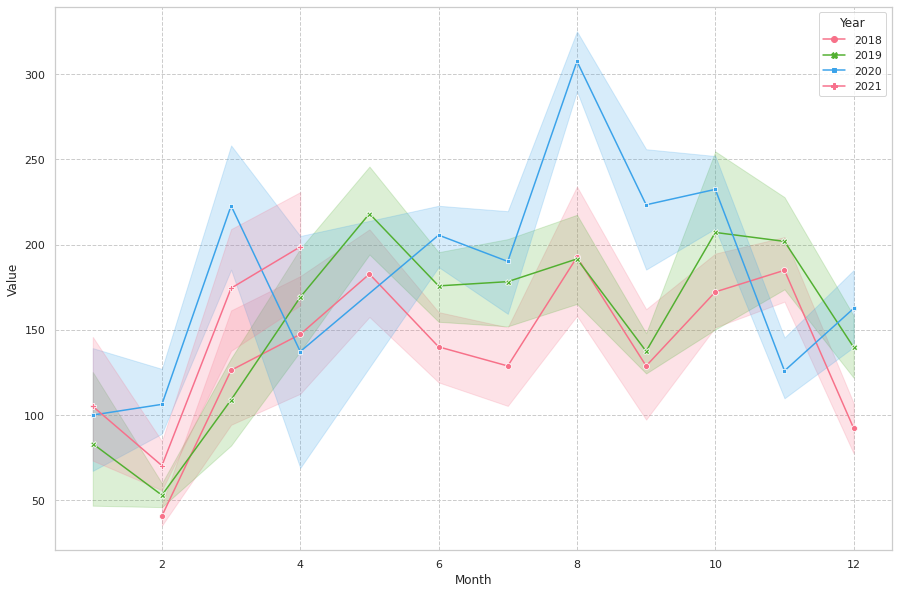

In [35]:
# 年度別入場者数

df11 = df7.loc[df7['Metric'].isin(['Quantity'])]
sns.lineplot(data=df11, x='Month', y='Value', hue='Year', style='Year',
            markers=True, dashes=False, palette="husl")

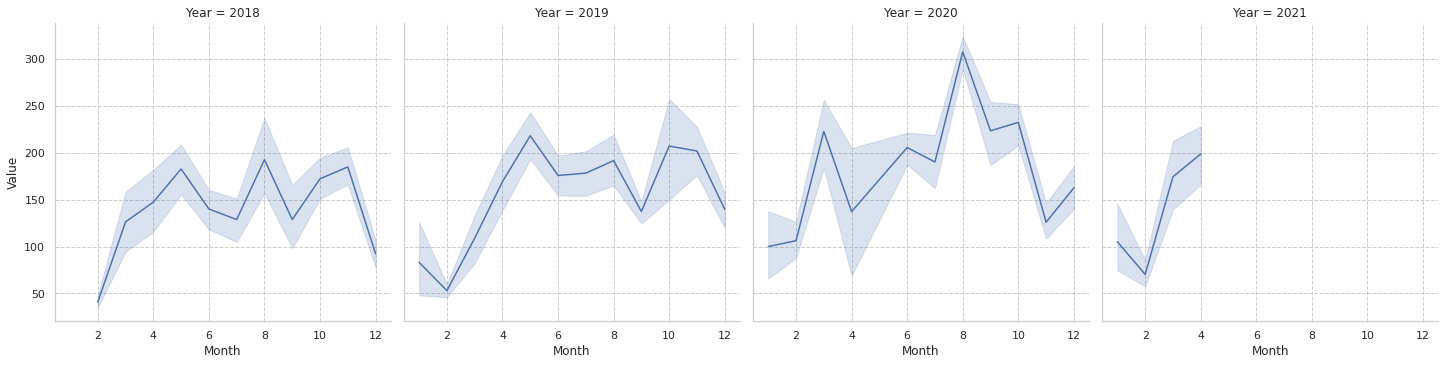

In [36]:
# 年度別入場者数、各年度グラフ

sns.relplot(data=df11, x='Month', y='Value', col='Year', kind="line")